In [ ]:
!unzip "/content/drive/MyDrive/eurosat_ms.zip" -d "/content/drive/MyDrive/eurosat_ms"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2885.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2854.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_297.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2828.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2970.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2977.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2882.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2853.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_290.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2744.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Residential_2821.tif  
  inflating: /content/drive/MyDrive/eurosat_ms/eurosat_ms/Re

In [ ]:
import os
import random  
import numpy as np
from PIL import Image, ImageFile
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn.functional as F_func  # Alias for torch.nn.functional

# Allow loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

##############################################
# Custom Transforms for Sentinel-2 (Domain B) #
##############################################
class SentinelToTensor(object):
    def __call__(self, x):
        # x: numpy array with shape (H, W, C) where C is expected (e.g., 13)
        # Convert to torch tensor with shape (C, H, W)
        return torch.from_numpy(x).permute(2, 0, 1).float()

class SentinelResize(object):
    def __init__(self, size):
        self.size = size  # size: (height, width)
    def __call__(self, x):
        # x: torch tensor of shape (C, H, W)
        x = F_func.interpolate(x.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False).squeeze(0)
        return x

#######################################
# Channel Attention Module (SE Block) #
#######################################
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

#########################
# ResNet Block for Generator
#########################
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

########################################
# Generator with Channel Attention
# (For conditional generation, G outputs only extra channels (10))
########################################
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features * 2
        # Residual Blocks
        for _ in range(n_residual_blocks):
            model += [ResnetBlock(in_features)]
        # Channel Attention Module
        model += [ChannelAttention(in_features, reduction=16)]
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(True)
            ]
            in_features = out_features
            out_features = in_features // 2
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7),  # output_nc will be 10 for G
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

#########################
# PatchGAN Discriminator#
#########################
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True)
        ]
        model += [
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True)
        ]
        model += [
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, True)
        ]
        model += [
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True)
        ]
        model += [nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


In [2]:
##########################################
# Dataset: Domain A (RGB) & Domain B (S2)
##########################################
class ImageDataset(Dataset):
    def __init__(self, root_A, root_B, transform_A=None, transform_B=None, sample_percentage=1.0):
        self.files_A = sorted(os.listdir(root_A))
        self.files_B = sorted(os.listdir(root_B))
        # Eğer sentinel2 dosyalarının sadece %10'unu kullanmak istiyorsanız:
        if sample_percentage < 1.0:
            sample_size = max(1, int(len(self.files_A) * sample_percentage))
            self.files_A = random.sample(self.files_A, sample_size)
        self.root_A = root_A
        self.root_B = root_B
        self.transform_A = transform_A
        self.transform_B = transform_B
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    def __getitem__(self, index):
        # Domain A: RGB image
        A_path = os.path.join(self.root_A, self.files_A[index % len(self.files_A)])
        img_A = Image.open(A_path).convert('RGB')
        if self.transform_A:
            img_A = self.transform_A(img_A)
        # Domain B: Sentinel-2 image with error handling
        attempts = 0
        while attempts < len(self.files_B):
            B_path = os.path.join(self.root_B, self.files_B[index % len(self.files_B)])
            try:
                img_B = tiff.imread(B_path)  # Expected shape: (channels, height, width)
                if img_B.ndim == 3 and img_B.shape[0] in [1, 13]:
                    img_B = np.moveaxis(img_B, 0, -1)  # Convert to (height, width, channels)
                if self.transform_B:
                    img_B = self.transform_B(img_B)
                break
            except Exception as e:
                print(f"Skipping file {B_path} due to error: {e}")
                index = (index + 1) % len(self.files_B)
                attempts += 1
        else:
            raise RuntimeError("No valid Sentinel-2 file found in dataset.")
        return {'A': img_A, 'B': img_B}

In [3]:
########################################
#          Training Settings           #
########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
n_epochs = 20
lr = 0.0002
lambda_cycle = 10.0
lambda_identity = 5.0

# Transformations for Domain A (RGB)
transform_A = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Custom transformations for Domain B (Sentinel-2: 13 channels)
transform_B = transforms.Compose([
    SentinelToTensor(),
    SentinelResize((64,64)),
    transforms.Normalize((0.5,)*13, (0.5,)*13)
])
input_nc_A = 3   # RGB images
input_nc_B = 13  # Sentinel-2 images (13 channels)

# Folders
band_folder = '/content/drive/MyDrive/eurosat_ms/eurosat_ms'
root_A = '/content/drive/MyDrive/generated_images'

print("Training is beginning. Target domain:", band_folder)

# Dataset with 10% of Sentinel-2 images selected randomly
dataset = ImageDataset(root_A=root_A, root_B=band_folder, transform_A=transform_A, transform_B=transform_B, sample_percentage=1.0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("Data length: ", len(dataloader))

# Models
# For mapping A -> B, G produces extra 10 channels.
# Final fake B is built by concatenating input RGB and generated extra channels,
# such that:
# - Index 0: G-generated extra channel (for b1)
# - Indices 1-3: real_A (RGB) → for b2, b3, b4
# - Indices 4-12: G-generated extra channels (for b5 ... b13)
G = Generator(input_nc_A, output_nc=10).to(device)
# For mapping B -> A, F remains unchanged (maps 13 channels to 3 channels)
F = Generator(input_nc_B, input_nc_A).to(device)

# Discriminators
D_A = Discriminator(input_nc_A).to(device)
D_B = Discriminator(input_nc_B).to(device)

# Loss Functions
criterion_GAN = nn.MSELoss()    # LSGAN loss
criterion_cycle = nn.L1Loss()   # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss

# Optimizers
optimizer_G = optim.Adam(list(G.parameters()) + list(F.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)  # RGB image (domain A)
        real_B = batch['B'].to(device)  # Sentinel-2 image (13 channels, domain B)

        # Real/Fake labels
        valid = torch.ones(real_A.size(0), 1, 30, 30, device=device)
        fake = torch.zeros(real_A.size(0), 1, 30, 30, device=device)

        # -----------------
        #  Generator Training
        # -----------------
        optimizer_G.zero_grad()
        # Identity loss is set to 0 in this conditional generation setup
        loss_identity = 0

        # --- Mapping A -> B ---
        fake_extra = G(real_A)  # G generates extra 10 channels from RGB input (real_A), shape: (batch, 10, H, W)
        # Construct final fake_B with preserved channel order:
        # - Index 0: fake_extra[:, 0, :, :] (G-generated for b1)
        # - Indices 1-3: real_A (preserved RGB for b2, b3, b4)
        # - Indices 4-12: fake_extra[:, 1:, :, :] (G-generated for b5 ... b13)
        fake_B = torch.empty(real_A.size(0), 13, real_A.size(2), real_A.size(3), device=device)
        fake_B[:, 0, :, :] = fake_extra[:, 0, :, :]
        fake_B[:, 1:4, :, :] = real_A
        fake_B[:, 4:, :, :] = fake_extra[:, 1:, :, :]

        output_D_B = D_B(fake_B)
        valid = torch.ones_like(output_D_B, device=device)
        fake  = torch.zeros_like(output_D_B, device=device)
        loss_GAN_G = criterion_GAN(output_D_B, valid)
        # loss_GAN_G = criterion_GAN(D_B(fake_B), valid)

        # --- Mapping B -> A ---
        fake_A = F(real_B)  # F maps 13-channel Sentinel-2 to 3-channel RGB
        loss_GAN_F = criterion_GAN(D_A(fake_A), valid)

        # --- Cycle Consistency Loss ---
        recov_A = F(fake_B)  # Cycle A -> B -> A: F(fake_B) should equal real_A
        loss_cycle_A = criterion_cycle(recov_A, real_A)

        fake_extra_2 = G(fake_A)  # Cycle B -> A -> B: G(fake_A) generates extra channels from fake_A
        recov_B = torch.empty(real_B.size(0), 13, real_B.size(2), real_B.size(3), device=device)
        recov_B[:, 0, :, :] = fake_extra_2[:, 0, :, :]
        recov_B[:, 1:4, :, :] = fake_A
        recov_B[:, 4:, :, :] = fake_extra_2[:, 1:, :, :]
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle

        # Total generator loss
        loss_G = loss_identity + loss_GAN_G + loss_GAN_F + loss_cycle
        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Discriminator A Training
        # -----------------------
        optimizer_D_A.zero_grad()
        loss_D_A_real = criterion_GAN(D_A(real_A), valid)
        loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A_total = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A_total.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Discriminator B Training
        # -----------------------
        optimizer_D_B.zero_grad()
        loss_D_B_real = criterion_GAN(D_B(real_B), valid)
        loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B_total = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B_total.backward()
        optimizer_D_B.step()

        if i % 50 == 0:
            print(f"[{band_folder}] Epoch [{epoch}/{n_epochs}] Batch [{i}/{len(dataloader)}] Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A_total.item():.4f} Loss_D_B: {loss_D_B_total.item():.4f}")

    # -----------------------
    # Save outputs at the end of each epoch
    # -----------------------
    output_dir = f'/content/drive/MyDrive/eurosat_ms/output/{os.path.basename(band_folder)}'
    os.makedirs(output_dir, exist_ok=True)

    # Select the first sample from the batch for saving (shape: (13, H, W))
    fake_B_sample = fake_B[0]

    # For true-color visualization, we want to use b2, b3, b4.
    # b2 → index 1, b3 → index 2, b4 → index 3.
    # True-color order: [Red, Green, Blue] = [b4, b3, b2] = indices [3, 2, 1].
    rgb_image = fake_B_sample[[3, 2, 1], :, :]
    # Manually scale from [-1,1] to [0,1]
    rgb_image = (rgb_image + 1) / 2.0
    save_image(rgb_image.cpu(), f'{output_dir}/fakeB_rgb_epoch_{epoch}.png', normalize=False)

    short_ir = fake_B_sample[[12, 8, 3], :, :]
    short_ir = (short_ir + 1) / 2.0
    save_image(short_ir.cpu(), f'{output_dir}/fakeB_short_ir_epoch_{epoch}.png', normalize=False)

    # Save full 13-channel image as TIFF:
    fake_B_np = fake_B_sample.cpu().detach().numpy()  # shape: (13, H, W)
    fake_B_np = np.transpose(fake_B_np, (1, 2, 0))       # shape: (H, W, 13)
    fake_B_np = (fake_B_np + 1) / 2.0  # Scale from [-1,1] to [0,1]
    fake_B_np = fake_B_np.astype(np.float32)
    tiff.imwrite(f'{output_dir}/fakeB_full_epoch_{epoch}.tif', fake_B_np)

    os.makedirs('/content/drive/MyDrive/eurosat_ms/models', exist_ok=True)
    checkpoint = {
        'epoch': epoch + 1,
        'G_state_dict': G.state_dict(),
        'F_state_dict': F.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict()
    }
    torch.save(checkpoint, f'/content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_{epoch+1}.pth')


os.makedirs('/content/drive/MyDrive/eurosat_ms/models', exist_ok=True)
torch.save(G.state_dict(), f'/content/drive/MyDrive/eurosat_ms/models/G_{os.path.basename(band_folder)}.pth')
torch.save(F.state_dict(), f'//content/drive/MyDrive/eurosat_ms/models/F_{os.path.basename(band_folder)}.pth')

Training is beginning. Target domain: /content/drive/MyDrive/eurosat_ms/eurosat_ms
Data length:  481
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [0/20] Batch [0/481] Loss_G: 31648.4375 Loss_D_A: 0.5953 Loss_D_B: 0.6650
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [0/20] Batch [50/481] Loss_G: 31553.7266 Loss_D_A: 0.1363 Loss_D_B: 0.0311
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [0/20] Batch [100/481] Loss_G: 31702.9199 Loss_D_A: 0.0851 Loss_D_B: 0.0090
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [0/20] Batch [150/481] Loss_G: 31663.1777 Loss_D_A: 0.0730 Loss_D_B: 0.0088
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [0/20] Batch [200/481] Loss_G: 31601.3711 Loss_D_A: 0.1837 Loss_D_B: 0.0045
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [0/20] Batch [250/481] Loss_G: 31418.1621 Loss_D_A: 0.0919 Loss_D_B: 0.0078
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [0/20] Batch [300/481] Loss_G: 31020.1074 Loss_D_A: 0.1604 Loss_D_B: 0.0020

In [3]:
!ls -lt /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_*.pth

-rw------- 1 root root 318378522 Mar 16 07:37 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_20.pth
-rw------- 1 root root 318378522 Mar 16 07:14 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_19.pth
-rw------- 1 root root 318378522 Mar 16 06:51 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_18.pth
-rw------- 1 root root 318378522 Mar 16 06:29 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_17.pth
-rw------- 1 root root 318378522 Mar 16 06:06 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_16.pth
-rw------- 1 root root 318378522 Mar 16 05:43 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_15.pth
-rw------- 1 root root 318378522 Mar 16 05:19 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_14.pth
-rw------- 1 root root 318378522 Mar 16 04:57 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_13.pth
-rw------- 1 root root 318378522 Mar 16 04:34 /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_12.pth
-

In [4]:
import torch
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
start_epoch = 20
n_epochs = 200
lr = 0.0002
lambda_cycle = 10.0
lambda_identity = 5.0

# Transformations for Domain A (RGB)
transform_A = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Custom transformations for Domain B (Sentinel-2: 13 channels)
transform_B = transforms.Compose([
    SentinelToTensor(),
    SentinelResize((64,64)),
    transforms.Normalize((0.5,)*13, (0.5,)*13)
])
input_nc_A = 3   # RGB images
input_nc_B = 13  # Sentinel-2 images (13 channels)

# Folders
band_folder = '/content/drive/MyDrive/eurosat_ms/eurosat_ms'
root_A = '/content/drive/MyDrive/generated_images'

print("Training is beginning. Target domain:", band_folder)

# Dataset with 10% of Sentinel-2 images selected randomly
dataset = ImageDataset(root_A=root_A, root_B=band_folder, transform_A=transform_A, transform_B=transform_B, sample_percentage=1.0)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("Data length: ", len(dataloader))

# Models
# For mapping A -> B, G produces extra 10 channels.
# Final fake B is built by concatenating input RGB and generated extra channels,
# such that:
# - Index 0: G-generated extra channel (for b1)
# - Indices 1-3: real_A (RGB) → for b2, b3, b4
# - Indices 4-12: G-generated extra channels (for b5 ... b13)
G = Generator(input_nc_A, output_nc=10).to(device)
# For mapping B -> A, F remains unchanged (maps 13 channels to 3 channels)
F = Generator(input_nc_B, input_nc_A).to(device)

# Discriminators
D_A = Discriminator(input_nc_A).to(device)
D_B = Discriminator(input_nc_B).to(device)

# Loss Functions
criterion_GAN = nn.MSELoss()    # LSGAN loss
criterion_cycle = nn.L1Loss()   # Cycle consistency loss
criterion_identity = nn.L1Loss()  # Identity loss

# Optimizers
optimizer_G = optim.Adam(list(G.parameters()) + list(F.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(0.5, 0.999))

model_dir = "/content/drive/MyDrive/eurosat_ms/models"
last_checkpoint = '/content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_20.pth'

if last_checkpoint:
    print(f"Loading checkpoint: {last_checkpoint}")

    # Checkpoint'i yükle
    checkpoint = torch.load(last_checkpoint)

    # Model ağırlıklarını yükle
    G.load_state_dict(checkpoint['G_state_dict'])
    F.load_state_dict(checkpoint['F_state_dict'])

    # Optimizer durumlarını yükle
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A_state_dict'])
    optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B_state_dict'])

    # Eğitime kaldığı epoch'tan devam etmek için epoch numarasını al
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")

else:
    print("No checkpoint found! Training will start from scratch.")
    start_epoch = 0


Training is beginning. Target domain: /content/drive/MyDrive/eurosat_ms/eurosat_ms
Data length:  481
Loading checkpoint: /content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_20.pth
Resuming training from epoch 20


In [ ]:
for epoch in range(start_epoch, n_epochs):
    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)  # RGB image (domain A)
        real_B = batch['B'].to(device)  # Sentinel-2 image (13 channels, domain B)

        # Real/Fake labels
        valid = torch.ones(real_A.size(0), 1, 30, 30, device=device)
        fake = torch.zeros(real_A.size(0), 1, 30, 30, device=device)

        # -----------------
        #  Generator Training
        # -----------------
        optimizer_G.zero_grad()
        # Identity loss is set to 0 in this conditional generation setup
        loss_identity = 0

        # --- Mapping A -> B ---
        fake_extra = G(real_A)  # G generates extra 10 channels from RGB input (real_A), shape: (batch, 10, H, W)
        # Construct final fake_B with preserved channel order:
        # - Index 0: fake_extra[:, 0, :, :] (G-generated for b1)
        # - Indices 1-3: real_A (preserved RGB for b2, b3, b4)
        # - Indices 4-12: fake_extra[:, 1:, :, :] (G-generated for b5 ... b13)
        fake_B = torch.empty(real_A.size(0), 13, real_A.size(2), real_A.size(3), device=device)
        fake_B[:, 0, :, :] = fake_extra[:, 0, :, :]
        fake_B[:, 1:4, :, :] = real_A
        fake_B[:, 4:, :, :] = fake_extra[:, 1:, :, :]

        output_D_B = D_B(fake_B)
        valid = torch.ones_like(output_D_B, device=device)
        fake  = torch.zeros_like(output_D_B, device=device)
        loss_GAN_G = criterion_GAN(output_D_B, valid)
        # loss_GAN_G = criterion_GAN(D_B(fake_B), valid)

        # --- Mapping B -> A ---
        fake_A = F(real_B)  # F maps 13-channel Sentinel-2 to 3-channel RGB
        loss_GAN_F = criterion_GAN(D_A(fake_A), valid)

        # --- Cycle Consistency Loss ---
        recov_A = F(fake_B)  # Cycle A -> B -> A: F(fake_B) should equal real_A
        loss_cycle_A = criterion_cycle(recov_A, real_A)

        fake_extra_2 = G(fake_A)  # Cycle B -> A -> B: G(fake_A) generates extra channels from fake_A
        recov_B = torch.empty(real_B.size(0), 13, real_B.size(2), real_B.size(3), device=device)
        recov_B[:, 0, :, :] = fake_extra_2[:, 0, :, :]
        recov_B[:, 1:4, :, :] = fake_A
        recov_B[:, 4:, :, :] = fake_extra_2[:, 1:, :, :]
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle

        # Total generator loss
        loss_G = loss_identity + loss_GAN_G + loss_GAN_F + loss_cycle
        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Discriminator A Training
        # -----------------------
        optimizer_D_A.zero_grad()
        loss_D_A_real = criterion_GAN(D_A(real_A), valid)
        loss_D_A_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A_total = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A_total.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Discriminator B Training
        # -----------------------
        optimizer_D_B.zero_grad()
        loss_D_B_real = criterion_GAN(D_B(real_B), valid)
        loss_D_B_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B_total = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B_total.backward()
        optimizer_D_B.step()

        if i % 50 == 0:
            print(f"[{band_folder}] Epoch [{epoch}/{n_epochs}] Batch [{i}/{len(dataloader)}] Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A_total.item():.4f} Loss_D_B: {loss_D_B_total.item():.4f}")

    # -----------------------
    # Save outputs at the end of each epoch
    # -----------------------
    output_dir = f'/content/drive/MyDrive/eurosat_ms/output/{os.path.basename(band_folder)}'
    os.makedirs(output_dir, exist_ok=True)

    # Select the first sample from the batch for saving (shape: (13, H, W))
    fake_B_sample = fake_B[0]

    # For true-color visualization, we want to use b2, b3, b4.
    # b2 → index 1, b3 → index 2, b4 → index 3.
    # True-color order: [Red, Green, Blue] = [b4, b3, b2] = indices [3, 2, 1].
    rgb_image = fake_B_sample[[3, 2, 1], :, :]
    # Manually scale from [-1,1] to [0,1]
    rgb_image = (rgb_image + 1) / 2.0
    save_image(rgb_image.cpu(), f'{output_dir}/fakeB_rgb_epoch_{epoch}.png', normalize=False)

    short_ir = fake_B_sample[[12, 8, 3], :, :]
    short_ir = (short_ir + 1) / 2.0
    save_image(short_ir.cpu(), f'{output_dir}/fakeB_short_ir_epoch_{epoch}.png', normalize=False)

    # Save full 13-channel image as TIFF:
    fake_B_np = fake_B_sample.cpu().detach().numpy()  # shape: (13, H, W)
    fake_B_np = np.transpose(fake_B_np, (1, 2, 0))       # shape: (H, W, 13)
    fake_B_np = (fake_B_np + 1) / 2.0  # Scale from [-1,1] to [0,1]
    fake_B_np = fake_B_np.astype(np.float32)
    tiff.imwrite(f'{output_dir}/fakeB_full_epoch_{epoch}.tif', fake_B_np)

    os.makedirs('/content/drive/MyDrive/eurosat_ms/models', exist_ok=True)
    checkpoint = {
        'epoch': epoch + 1,
        'G_state_dict': G.state_dict(),
        'F_state_dict': F.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict()
    }
    torch.save(checkpoint, f'/content/drive/MyDrive/eurosat_ms/models/checkpoint_epoch_{epoch+1}.pth')

    if (epoch + 1) % 20 == 0:
      torch.save(G.state_dict(), f'/content/drive/MyDrive/eurosat_ms/models/G_{os.path.basename(band_folder)}.pth')
      torch.save(F.state_dict(), f'//content/drive/MyDrive/eurosat_ms/models/F_{os.path.basename(band_folder)}.pth')

os.makedirs('/content/drive/MyDrive/eurosat_ms/models', exist_ok=True)
torch.save(G.state_dict(), f'/content/drive/MyDrive/eurosat_ms/models/G_{os.path.basename(band_folder)}.pth')
torch.save(F.state_dict(), f'//content/drive/MyDrive/eurosat_ms/models/F_{os.path.basename(band_folder)}.pth')

[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [20/200] Batch [0/481] Loss_G: 31689.8164 Loss_D_A: 0.7351 Loss_D_B: 0.6053
[/content/drive/MyDrive/eurosat_ms/eurosat_ms] Epoch [20/200] Batch [50/481] Loss_G: 31140.9160 Loss_D_A: 0.0449 Loss_D_B: 0.0063


Multispectral image saved: /content/generated_multispectral_256.tif


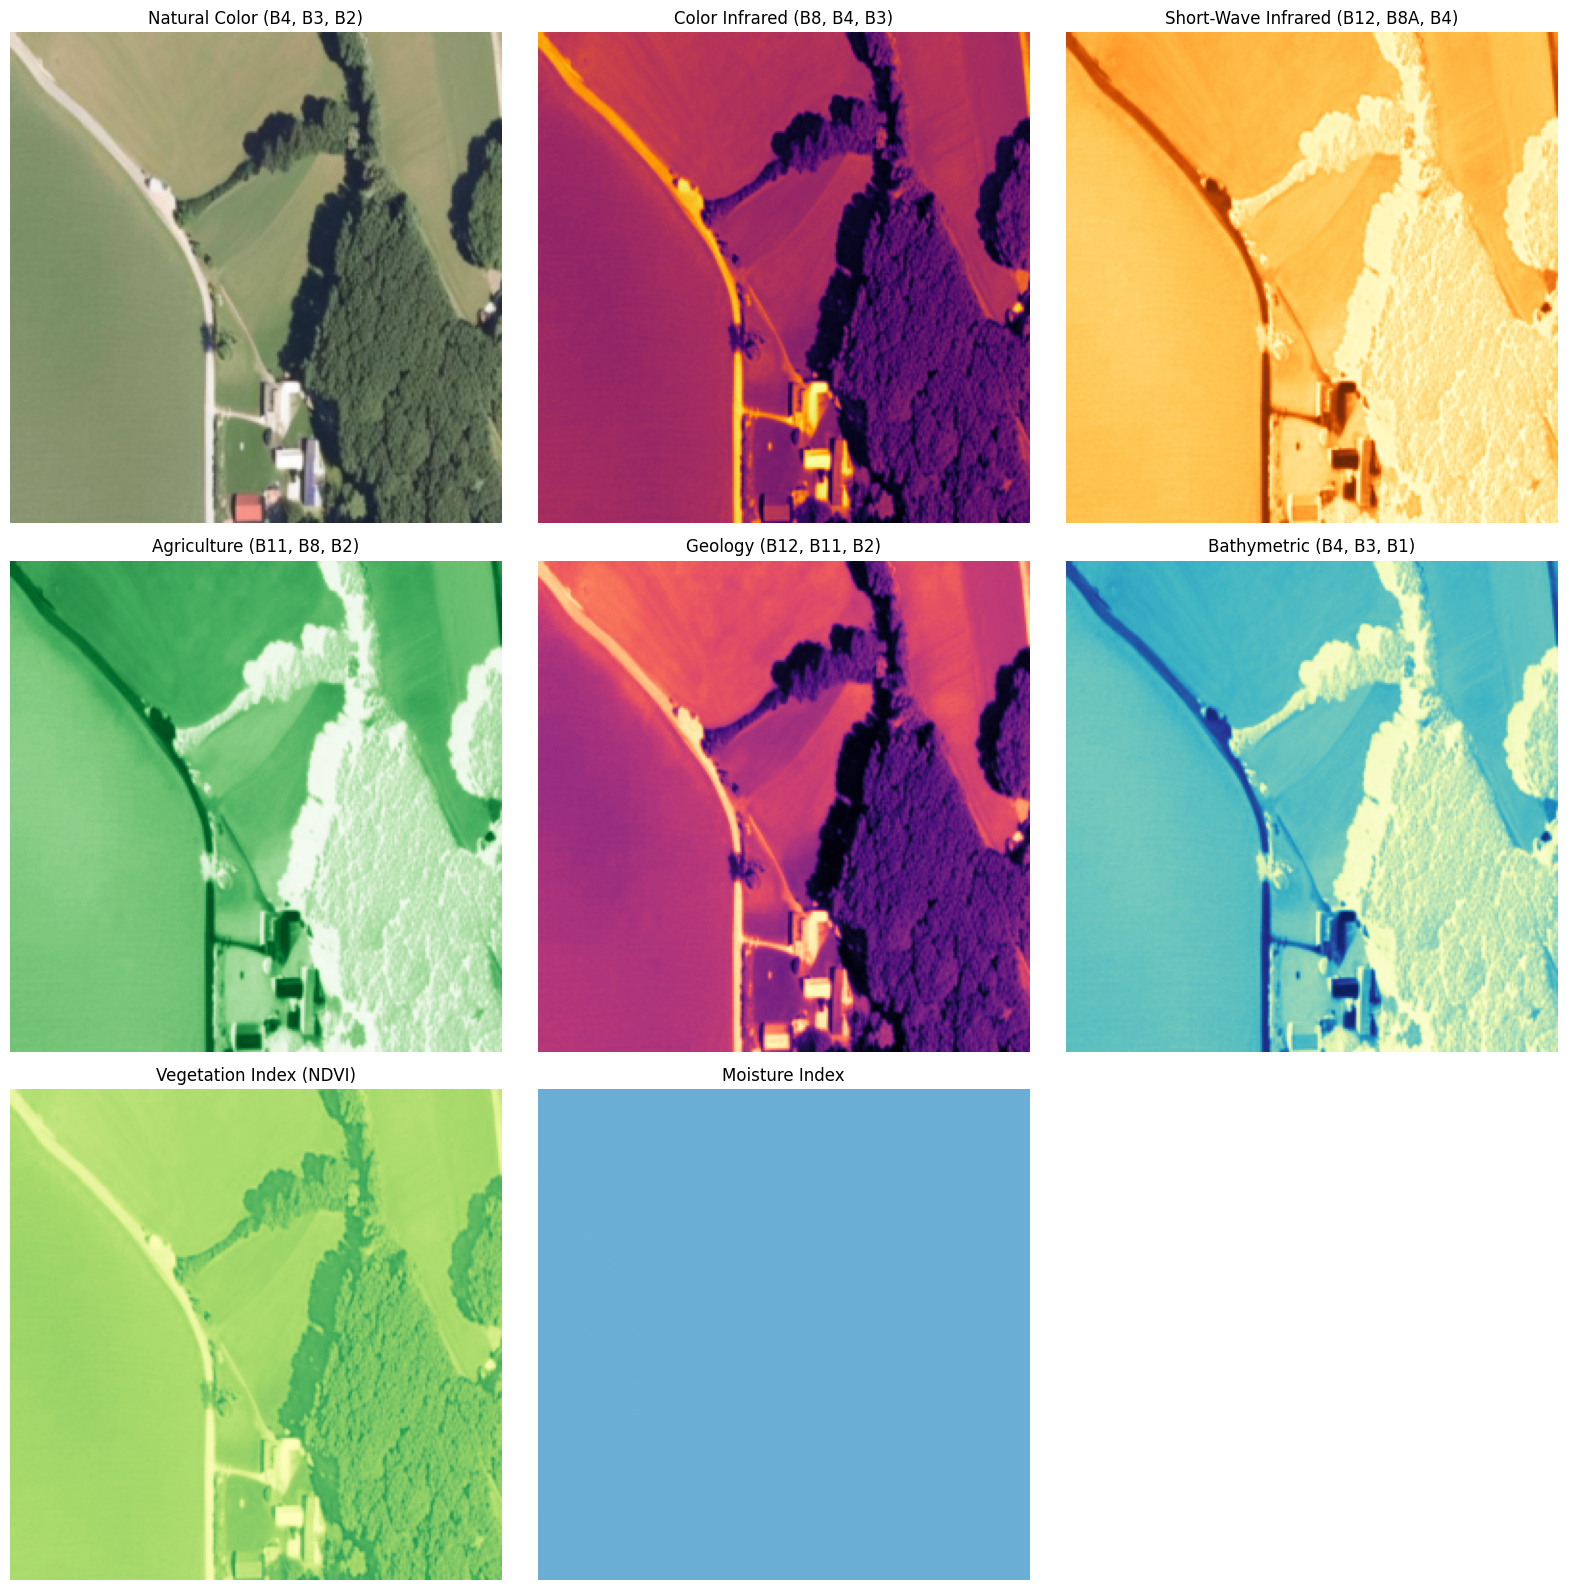

In [13]:
import torch
import torchvision.transforms as transforms
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image

# ---------------------------
# Model ve Girdi Ayarları
# ---------------------------
model_path = "/content/drive/MyDrive/eurosat_ms/models/G_eurosat_ms.pth"  # Model dosya yolunu güncelle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator modelini yükle (3 giriş, 10 çıkış kanalı; G, RGB'den ekstra 10 kanal üretir)
G = Generator(input_nc=3, output_nc=10).to(device)
G.load_state_dict(torch.load(model_path, map_location=device))
G.eval()

# w1172713800_CH_18_generated.jpg
# w1171277558_CH_18_generated.jpg
# w1171270719_CH_18_generated.jpg
# w1169720360_CH_21_generated.jpg
# w1169335568_DE__generated.jpg
# w1165126033_DE__generated.jpg
# Girdi görüntüsünü yükle (RGB)
rgb_path = "/content/drive/MyDrive/generated_images/w1165126033_DE__generated.jpg"  # Test RGB görüntü yolu
input_image = Image.open(rgb_path).convert("RGB")

# Girdi için dönüşüm: 256x256, normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
input_tensor = transform(input_image).unsqueeze(0).to(device)  # (1,3,256,256)

# ---------------------------
# Model İlerlemesi: Multispektral Görüntü Üretimi
# ---------------------------
with torch.no_grad():
    fake_extra = G(input_tensor)  # (1, 10, H, W)
    # Üretilen çıktıyı 256x256'ye ölçeklendir
    fake_extra = torch.nn.functional.interpolate(fake_extra, size=(256, 256), mode='bilinear', align_corners=False)

# Tam 13 kanallı multispektral görüntüyü oluştur:
# - G, 10 kanal üretir; RGB kanalları (b2, b3, b4) korunup,
# - İlk kanal G tarafından üretilir, kalan 9 kanal G tarafından üretilir.
fake_B = torch.empty(1, 13, 256, 256, device=device)
fake_B[:, 0, :, :] = fake_extra[:, 0, :, :]  # Kanal 1 (G üretti)
fake_B[:, 1:4, :, :] = torch.nn.functional.interpolate(input_tensor, size=(256, 256), mode='bilinear', align_corners=False)  # Kanallar 2-4: RGB (b2, b3, b4)
fake_B[:, 4:, :, :] = fake_extra[:, 1:, :, :]  # Kanallar 5-13: G üretti

# Sonucu CPU'ya al, [-1,1] -> [0,1] ölçeğine getir, (H, W, 13) formatına dönüştür
fake_B_np = fake_B.squeeze(0).cpu().numpy()  # (13, 256, 256)
fake_B_np = (fake_B_np + 1) / 2.0
fake_B_np = np.transpose(fake_B_np, (1, 2, 0))  # (256, 256, 13)

# Opsiyonel: TIFF olarak kaydet
output_path = "/content/generated_multispectral_256.tif"
# tiff.imwrite(output_path, fake_B_np.astype(np.float32))
print(f"Multispectral image saved: {output_path}")

# ---------------------------
# Spektral Analiz ve Görselleştirme
# ---------------------------
# Bant indeksleri (Sentinel-2: B1 index 0, B2 index 1, ..., B12 index 12; B8A index 8)
# İstenen kompozitler:
spectral_composites = {
    "Natural Color (B4, B3, B2)": {"bands": [1, 2, 3], "display": "rgb"},
    "Color Infrared (B8, B4, B3)": {"bands": [2, 3, 7], "cmap": "inferno"},
    "Short-Wave Infrared (B12, B8A, B4)": {"bands": [3, 8, 12], "cmap": "YlOrBr"},
    "Agriculture (B11, B8, B2)": {"bands": [1, 7, 10], "cmap": "Greens"},
    "Geology (B12, B11, B2)": {"bands": [1, 10, 12], "cmap": "magma"},
    "Bathymetric (B4, B3, B1)": {"bands": [0, 2, 3], "cmap": "YlGnBu"}
}

# Vegetation Index (NDVI): (B8 - B4)/(B8 + B4) --> (index 7 - index 3)
NDVI = (fake_B_np[:, :, 7] - fake_B_np[:, :, 3]) / (fake_B_np[:, :, 7] + fake_B_np[:, :, 3] + 1e-6)

# Moisture Index: (B8A - B11)/(B8A + B11) --> (index 8 - index 11)
Moisture = (fake_B_np[:, :, 8] - fake_B_np[:, :, 11]) / (fake_B_np[:, :, 8] + fake_B_np[:, :, 11] + 1e-6)

# Renk haritaları ayarları:
# - Short-Wave Infrared, Agriculture ve Vegetation Index: "Greens"
# - Color Infrared: "inferno"
# - Moisture Index: "Blues"
index_colormaps = {
    "Vegetation Index (NDVI)": 'RdYlGn',
    "Moisture Index": "Blues"
}

# Toplamda 6 kompozit + 2 indeks = 8 panel
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
plot_idx = 0

# Kompozit görüntüleri çizelim
for title, info in spectral_composites.items():
    bands = info["bands"]
    if info.get("display", "") == "rgb":
        # RGB görüntü: Kanalları doğrudan kullan
        img = fake_B_np[:, :, bands]
        axs[plot_idx].imshow(img)
    else:
        # Diğer kompozitler için, üç banttan ortalama alarak tek kanallı görüntü elde edilebilir
        # (Alternatif olarak, üç bantlı kompozit de gösterilebilir; burada colormap uygulanması için ortalama alıyoruz)
        img = np.mean(fake_B_np[:, :, bands], axis=2)
        cmap = info.get("cmap", None)
        axs[plot_idx].imshow(img, cmap=cmap)
    axs[plot_idx].set_title(title, fontsize=12)
    axs[plot_idx].axis("off")
    plot_idx += 1

# Vegetation Index (NDVI)
axs[plot_idx].imshow(NDVI, cmap=index_colormaps["Vegetation Index (NDVI)"], vmin=-1, vmax=1)
axs[plot_idx].set_title("Vegetation Index (NDVI)", fontsize=12)
axs[plot_idx].axis("off")
plot_idx += 1

# Moisture Index
axs[plot_idx].imshow(Moisture, cmap=index_colormaps["Moisture Index"], vmin=-1, vmax=1)
axs[plot_idx].set_title("Moisture Index", fontsize=12)
axs[plot_idx].axis("off")
plot_idx += 1

# Kullanılmayan panel varsa kapat
while plot_idx < len(axs):
    axs[plot_idx].axis("off")
    plot_idx += 1

plt.tight_layout()
plt.show()
